# Get LAI data using openEO

The Leaf Area Index (LAI) is defined as half the total area of a canopy's green elements per unit of horizontal ground area. The satellite-derived value corresponds to the total green LAI of all the canopy layers, including the understory, which may represent a significant contribution, particularly for forests. It is recognized as an Essential Climate Variable (ECV) by the Global Climate Observing System (GCOS) and is widely used in climate monitoring, ecosystem assessment, and land surface modelling.

In this notebook, we will demonstrate how to access and process LAI data using the openEO API in the Copernicus Data Space Ecosystem (CDSE). Two main approaches will be covered: (i) accessing the operational LAI product and (ii) computing LAI on demand using the BioPAR openEO service.

All processing is executed in the cloud on the CDSE infrastructure using openEO API, so no local data download or heavy computation is required. Therefore, if you don't yet have an account on CDSE, please register at [https://dataspace.copernicus.eu](https://dataspace.copernicus.eu)


In this notebook, you will learn how to:
* Connect to the CDSE openEO federation backend
* Directly access the [Copernicus Global Land Service](https://land.copernicus.eu/en/products/vegetation) LAI collection hosted by [Terrascope](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html#terrascope)
* Compute LAI on demand using the BioPAR openEO service
* Run EO processing workflows entirely in the cloud and download only the final results

Prerequisites
* A CDSE account (register at https://dataspace.copernicus.eu)
* Basic familiarity with Python and Earth Observation data 

## Introduction

Before we jump into the practical steps, let's briefly understand what is openEO and the concepts involved in accessing LAI data.

### What is openEO?

openEO is an open-source standard that simplifies access to and processing of Earth Observation (EO) data.
Instead of downloading and processing large satellite datasets locally, openEO allows users to:
* Access EO data directly where it is stored
* Run scalable processing workflows in the cloud
* Save workflows as User-Defined Processes (UDPs) such as the BioPAR service for LAI computation
* Reshare and reuse UDPs as services

This enables faster, more reproducible, and easier-to-scale EO data analysis.

### openEO workflows

Before using the BioPAR openEO service, it is useful to understand the general structure of an openEO workflow.

Most openEO workflows follow the same high-level pattern:
1. Connect to an openEO backend
2. Load collection for a specific spatial and temporal extent
3. Build a processing workflow (also called a *process graph*) using openEO processes
4. Execute the workflow on the backend

For a full introduction to these concepts, please refer to the official openEO *Getting Started* notebook:  
https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb


### openEO User-Defined Processes and Services

While building workflows many times from scratch can be tedious, openEO supports the creation of reusable processing chains. 

Such workflows can be encapsulated as **User-Defined Processes (UDPs)** and shared as **services**. These services:
- Hide the complexity of the underlying processing workflow
- Require fewer inputs from the user
- Ensure consistent and reproducible results

The **BioPAR openEO service** is one such service. It encompasses a comprehensive processing workflow for deriving biophysical vegetation parameters from Sentinel-2 data.

Let's get started by installing the required Python package.

## Installation

The only package required to run this service is the `openeo` Python client, which can be installed via pip:

```

pip install openeo

```

In [1]:
import openeo

Next, let's set up a connection to an openEO backend, in this case the Copernicus Data Space Ecosystem (CDSE) federation. 

*Don't get confused by the term "federation" here; it simply is referring to a group service providers in the ecosystem. Since are interested in collection hosted by Terrascope, we are using the federation endpoint. To connect to CDSE backend use "openeo.dataspace.copernicus.eu"* 

For more information visit:
* [Documentation](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html)
* [Federated processing example](https://github.com/Open-EO/openeo-community-examples/blob/main/python/Federation/FederatedProcessing.ipynb)


You can authenticate using your credentials as shown below.

In [2]:
connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Method 1: Accessing operational LAI product from Copernicus Global Land Service

The first method demonstrates how to load the global LAI product, CGLS_LAI_V2_GLOBAL. Let us first identify the available collection for the LAI product. We can do this by listing all available collections and filtering for those related to LAI.

In [4]:
collections = connection.list_collections()

for collection in collections:
    title = collection.get("title", "")
    cid = collection.get("id", "")
    if "LAI" in title or "LAI" in cid:
        print(f"ID: {cid}, Title: {title}")


ID: CGLS_LAI300_V1_GLOBAL, Title: Copernicus Global Land LAI product V1, 300m resolution, 10-daily
ID: TERRASCOPE_S2_LAI_V2, Title: Sentinel-2 LAI last 2 years over Europe + selected areas, by Terrascope.
ID: CGLS_LAI_V2_GLOBAL, Title: Copernicus Global Land LAI product V2, 1km resolution, 10-daily


In [5]:
connection.describe_collection("CGLS_LAI_V2_GLOBAL")

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['LAI']},
  't': {'extent': ['1999-01-01T00:00:00Z', '2020-06-30T00:00:00Z'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180.00446428571428, 179.9955357],
   'reference_system': 4326,
   'step': 0.008928571428584,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-59.9955357, 80.0044643],
   'reference_system': 4326,
   'step': 0.008928571428569,
   'type': 'spatial'}},
 'description': 'Global LAI at 1km resolution, 10-daily. The Leaf Area Index is defined as half the total area of green elements of the canopy per unit horizontal ground area. The satellite-derived value corresponds to the total green LAI of all the canopy layers, including the understory which may represent a very significant contribution, particularly for forests. Practically, the LAI quantifies the thickness of the vegetation cover.',
 'extent': {'spatial': {'bbox': [[-180.00446428571428,
     -59.9955357,
     179.9955357,
     80.0044643]]},
  'temporal': {'interval': [['1999-01-01T00:00:00Z',
     '2020-06-30T00:00:00Z']]}},
 'id': 'CGLS_LAI_V2_GLOBAL',
 'license': 'free',
 'links': [{'href': 'https://land.copernicus.eu/global/products/lai',
   'rel': 'alternate',
   'title': 'Product web page.'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'root'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'parent'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections/CGLS_LAI_V2_GLOBAL',
   'rel': 'self'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'federation:backends': ['terrascope'],
  'instruments': ['SPOT/VEGETATION', 'PROBA-V'],
  'raster:bands': [{'data_type': 'uint8',
    'name': 'LAI',
    'nodata': 255,
    'offset': 0,
    'sampling': 'area',
    'scale': 0.0333333,
    'spatial_resolution': 1000,
    'statistics': {'maximum': 210, 'minimum': 0}}]},
 'title': 'Copernicus Global Land LAI product V2, 1km resolution, 10-daily'}

Copernicus Global Land LAI V2 provides global LAI data at 1km spatial resolution and 10-day temporal resolution covering the period from 1999 to June 2020 from SPOT/VEGETATION and PROBA-V data. Detailed product information, including scientific background, algorithm description, and validation reports, is available on the Copernicus Land Monitoring Service vegetation products webpage at https://land.copernicus.eu/en/products/vegetation.

In the following cell, we load the LAI collection for a specific area of interest and temporal extent.

In [7]:
lai_1km = connection.load_collection(
    "CGLS_LAI_V2_GLOBAL",
    temporal_extent=["2019-01-01", "2019-02-01"],
    spatial_extent={"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
    bands=["LAI"],
)

In [8]:
# apply offset and rescale
lai_1km = lai_1km.apply(lambda x: 0.0333333 * x +0.0)

As openEO follows a lazy execution model, no processing is done yet. We have just defined the data we want to work with. As a user you can now build more complex processing workflows using openEO processes. Advance usecases using openEO for EO data processing can be found in the [openEO community examples repository](https://github.com/Open-EO/openeo-community-examples/tree/main/python)

In this example, we will keep it simple and just create a job to download the data. For more information on openEO batch jobs, please refer to the [openEO documentation](https://open-eo.github.io/openeo-python-client/batch_jobs.html).

In [9]:
job = lai_1km.create_job(out_format="GTiff", title="LAI_1km_Job")
job.start_and_wait()

0:00:00 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': send 'start'
0:00:09 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': created (progress 0%)
0:00:14 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': queued (progress 0%)
0:00:21 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': queued (progress 0%)
0:00:29 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': queued (progress 0%)
0:00:39 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': queued (progress 0%)
0:00:52 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': running (progress 6.9%)
0:01:08 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': running (progress 9.1%)
0:01:27 Job 'terrascope-j-2601271340084df18b7bc846ca99a4f2': finished (progress 100%)


<BatchJob job_id='terrascope-j-2601271340084df18b7bc846ca99a4f2'>

Once a batch job is finished you can get a handle to the results (which can be a single file or multiple files) and download them to a local directory.

In [10]:
results = job.get_results()
results.download_files("data/lai_1km")

[PosixPath('data/lai_1km/openEO_2019-01-10Z.tif'),
 PosixPath('data/lai_1km/openEO_2019-01-20Z.tif'),
 PosixPath('data/lai_1km/openEO_2019-01-31Z.tif'),
 PosixPath('data/lai_1km/job-results.json')]

### Method 2: On-demand LAI computation with BioPAR UDP

The second method presented in this notebook is the on-demand computation of LAI using the BioPAR openEO service. 

As mentioned earlier, the BioPAR openEO service is a reusable processing component (called a User-Defined Process, or UDP). It isprovided by VITO/Terrascope through the [Copernicus Data Space Ecosystem (CDSE)](https://marketplace-portal.dataspace.copernicus.eu/catalogue/app-details/21) and the [APEx Algorithm Catalogue](https://algorithm-catalogue.apex.esa.int/apps/biopar#biophysical-parameters) for on-demand LAI computation. 
  
The service:
* Uses Sentinel-2 Level-2A data from CDSE
* Performs cloud masking
* Applies validated BioPAR retrieval models
* Returns ready-to-use biophysical products


To compute a specific product from the BioPAR service, we call the BioPAR process through an active openEO connection, which returns a datacube containing the requested data. In this case, it requires:
- `biopar_type`: The type of biophysical parameter to compute (e.g., 'FAPAR', 'FCOVER', 'LAI', 'CCC', 'CWC').
- `temporal_extent`: The time range for which the data is requested.
- `spatial_extent`: The area of interest. It can be a feature collection or bounding box coordinates.

The namespace parameter references a publicly accessible JSON file that defines the process graph for the BIOPAR algorithm. This graph summarizes all the steps the service performs on Sentinel-2 data to derive the requested parameter.

In [11]:
# Create a processing graph from the BIOPAR process using an active openEO connection
lai_biopar = connection.datacube_from_process(
        "biopar", 
        namespace = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/refs/heads/main/algorithm_catalog/vito/biopar/openeo_udp/biopar.json",
        temporal_extent = ["2020-05-06", "2020-05-30"],
        spatial_extent= {"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
        biopar_type = 'LAI'
        )

In [12]:
job = lai_biopar.create_job(out_format="GTiff", title="BIOPAR_LAI_Job")
job.start_and_wait()

0:00:00 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': send 'start'
0:00:19 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': created (progress 0%)
0:00:24 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': created (progress 0%)
0:00:31 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': created (progress 0%)
0:00:39 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': created (progress 0%)
0:00:49 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:01:02 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:01:17 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:01:36 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:02:01 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:02:31 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:03:08 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': running (progress N/A)
0:03:57 Job 'cdse-j-2601271343234d7eb1e6867636cad65f': finished (progress 100%

<BatchJob job_id='cdse-j-2601271343234d7eb1e6867636cad65f'>

In [13]:
results = job.get_results()
results.download_files("data/lai_biopar")

[PosixPath('data/lai_biopar/openEO_2020-05-07Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-12Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-15Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-17Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-20Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-25Z.tif'),
 PosixPath('data/lai_biopar/openEO_2020-05-27Z.tif'),
 PosixPath('data/lai_biopar/job-results.json')]

## Quick visualization

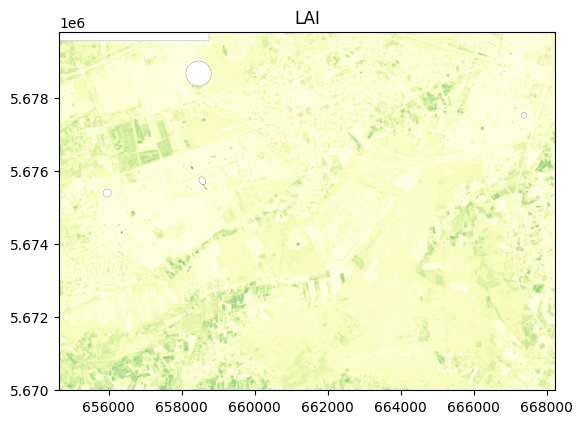

In [14]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

tif_file = "data/lai_biopar/openEO_2020-05-07Z.tif"

with rasterio.open(tif_file) as src:
    data = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

plt.imshow(data, cmap="YlGn", extent=extent)
plt.title("LAI")
plt.show()


Therefore, by using any of these approaches either the operational Copernicus land product access or on-demand LAI computation, user can obtain LAI data for their area and time of interest. Together, these workflows illustrate how openEO can be used as a unified interface supporting reproducible, scalable land and climate monitoring applications.